<a href="https://colab.research.google.com/github/julianVelandia/RedesNeuronalesConPyTorch/blob/master/redes-neuronales-recurrentes/5_3_Proyecto_de_Redes_Neuronales_Recurrentes_FULL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de Precios de Acciones con RNN usando PyTorch




In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


## Función para Descargar Datos Históricos

Se define una función para descargar datos históricos de precios de acciones usando la librería `yfinance`. Luego, se descargan los datos de las acciones de Apple (AAPL).


In [ ]:

def download_data(ticker, start_date, end_date):
    """
    Descarga los datos históricos de precios de acciones para un ticker específico.
    """
    return yf.download(ticker, start=start_date, end=end_date)

data = download_data('AAPL', '2020-01-01', '2023-01-01')


[*********************100%***********************]  1 of 1 completed


## Función para Análisis de Datos

En esta celda, se analizan los datos descargados mostrando un resumen estadístico y una visualización del precio de cierre a lo largo del tiempo.


Primeras filas del dataset:
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.876114  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.167618  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.742653  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.400551  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.565193  132079200

Descripción estadística:
             Open        High         Low       Close   Adj Close  \
count  756.000000  756.000000  756.000000  756.000000  756.000000   
mean   130.231998  131.892775  128.614983  130.311812  128.081748   
std     30.596429   30.841435   30.287325   30.566496   30.528398   
min     57.020000   57.125000   53.152500   56.092499   54.569729   
25%    115.924374  117.275000  114.129997  115.739374  113.105

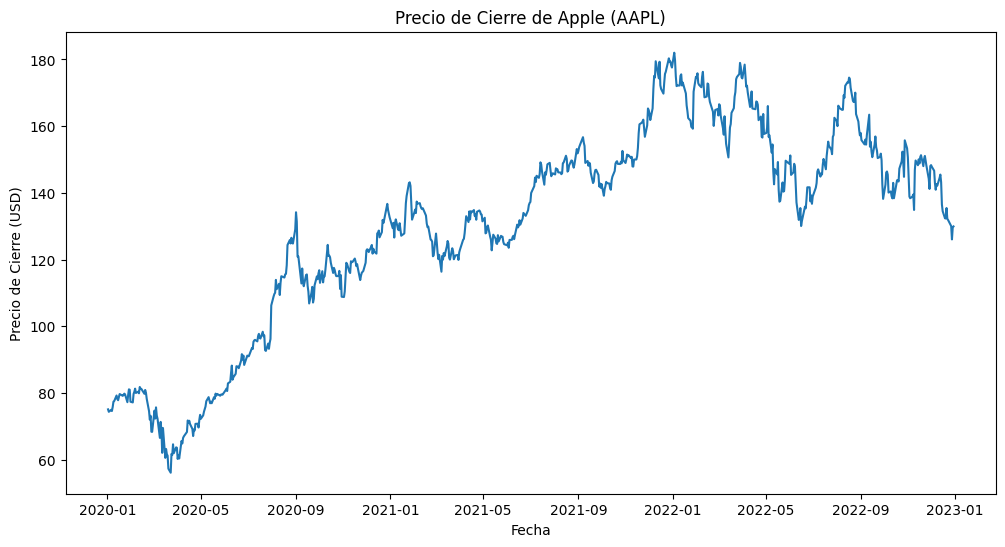

In [ ]:

def analyze_data(data):
    """
    Analiza y muestra un resumen estadístico del conjunto de datos.
    """
    print("Primeras filas del dataset:")
    print(data.head())

    print("\nDescripción estadística:")
    print(data.describe())

    plt.figure(figsize=(12, 6))
    plt.title('Precio de Cierre de Apple (AAPL)')
    plt.plot(data['Close'])
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre (USD)')
    plt.show()

analyze_data(data)


## Función para Normalizar y Crear Secuencias

En esta celda, se normalizan los datos y se crean secuencias de longitud fija que serán usadas como entrada para el modelo RNN. Finalmente, se dividen los datos en conjuntos de entrenamiento y prueba.


In [ ]:

def normalize_data(data):
    """
    Normaliza los datos entre 0 y 1.
    """
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def create_sequences(data, sequence_length):
    """
    Crea secuencias de datos para la RNN con una longitud específica.
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Preprocesamiento de los datos
close_data = data['Close'].values.reshape(-1, 1)
print("Primeros 5 valores de close_data:")
print(close_data[:5])

scaled_data = normalize_data(close_data)
print("\nPrimeros 5 valores de scaled_data (normalizados):")
print(scaled_data[:5])

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)
print("\nForma de X e Y después de crear secuencias:")
print("X:", X.shape)
print("y:", y.shape)

# Convertir a tensores de PyTorch
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
print("\nTamaño de X después de convertir a tensores:")
print(X.size())
print("Tamaño de y después de convertir a tensores:")
print(y.size())

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print("\nTamaño de X_train:", X_train.size())
print("Tamaño de y_train:", y_train.size())
print("Tamaño de X_test:", X_test.size())
print("Tamaño de y_test:", y_test.size())


Primeros 5 valores de close_data:
[[75.08750153]
 [74.35749817]
 [74.94999695]
 [74.59750366]
 [75.79750061]]

Primeros 5 valores de scaled_data (normalizados):
[[0.15085277]
 [0.14505529]
 [0.14976075]
 [0.14696135]
 [0.15649137]]

Forma de X e Y después de crear secuencias:
X: (696, 60, 1)
y: (696, 1)

Tamaño de X después de convertir a tensores:
torch.Size([696, 60, 1])
Tamaño de y después de convertir a tensores:
torch.Size([696, 1])

Tamaño de X_train: torch.Size([556, 60, 1])
Tamaño de y_train: torch.Size([556, 1])
Tamaño de X_test: torch.Size([140, 60, 1])
Tamaño de y_test: torch.Size([140, 1])


## Definición del Modelo RNN con LSTM en PyTorch

Aquí se define la arquitectura del modelo RNN.


In [ ]:
class StockPredictor(nn.Module):
    """
    Modelo RNN para predecir precios de acciones.
    """
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(StockPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq, hidden_cell):
        """
        Realiza la propagación hacia adelante en la red.
        """
        rnn_out, hidden_cell = self.rnn(input_seq, hidden_cell)
        predictions = self.linear(rnn_out[:, -1])
        return predictions, hidden_cell

    def init_hidden(self, batch_size):
        """
        Inicializa el estado oculto de la RNN.
        """
        return torch.zeros(1, batch_size, self.hidden_layer_size)

# Instanciar el modelo
model = StockPredictor()

# Definir el optimizador y la función de pérdida
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Función para Entrenamiento del Modelo

En esta celda, se entrena el modelo RNN usando los datos de entrenamiento. Se muestra la pérdida en cada quinta época para monitorear el progreso.


In [ ]:
def train_model(model, X_train, y_train, epochs=25):
    """
    Entrena el modelo de RNN con los datos de entrenamiento.
    """
    for i in range(epochs):
      for idx in range(len(X_train)):
        seq = X_train[idx]
        label = X_train[idx]

        optimizer.zero_grad()

        # Inicializar el estado oculto para cada secuencia
        hidden_cell = model.init_hidden(1)

        y_pred, hidden_cell = model(seq.unsqueeze(0), hidden_cell)
        single_loss = loss_function(y_pred, label.unsqueeze(0))
        single_loss.backward()
        optimizer.step()

train_model(model, X_train, y_train, epochs=25)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 60, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Función para Evaluación y Predicción

Se evalúa el modelo usando los datos de prueba, y se calculan las predicciones junto con el error cuadrático medio (RMSE).


In [ ]:

def evaluate_model(model, X_test, y_test):
    """
    Evalúa el modelo y realiza predicciones sobre los datos de prueba.
    """
    model.eval()
    predictions = []
    for seq in X_test:
        with torch.no_grad():
            hidden_cell = model.init_hidden(1)

            y_pred, hidden_cell = model(seq.unsqueeze(0), hidden_cell)
            predictions.append(y_pred.item())

    predictions = np.array(predictions).reshape(-1, 1)
    predictions = predictions * (np.max(close_data) - np.min(close_data)) + np.min(close_data)

    # Calcular el RMSE
    rmse = np.sqrt(np.mean((predictions - (y_test.numpy() * (np.max(close_data) - np.min(close_data)) + np.min(close_data)))**2))
    print(f'Root Mean Squared Error: {rmse}')

    return predictions

# Evaluar el modelo
predictions = evaluate_model(model, X_test, y_test)


Root Mean Squared Error: 11.219646599282274


## Función para Visualización de Resultados


Esta celda visualiza los resultados de las predicciones comparadas con los valores reales de cierre de las acciones.


<ipython-input-12-a42a58f10aeb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


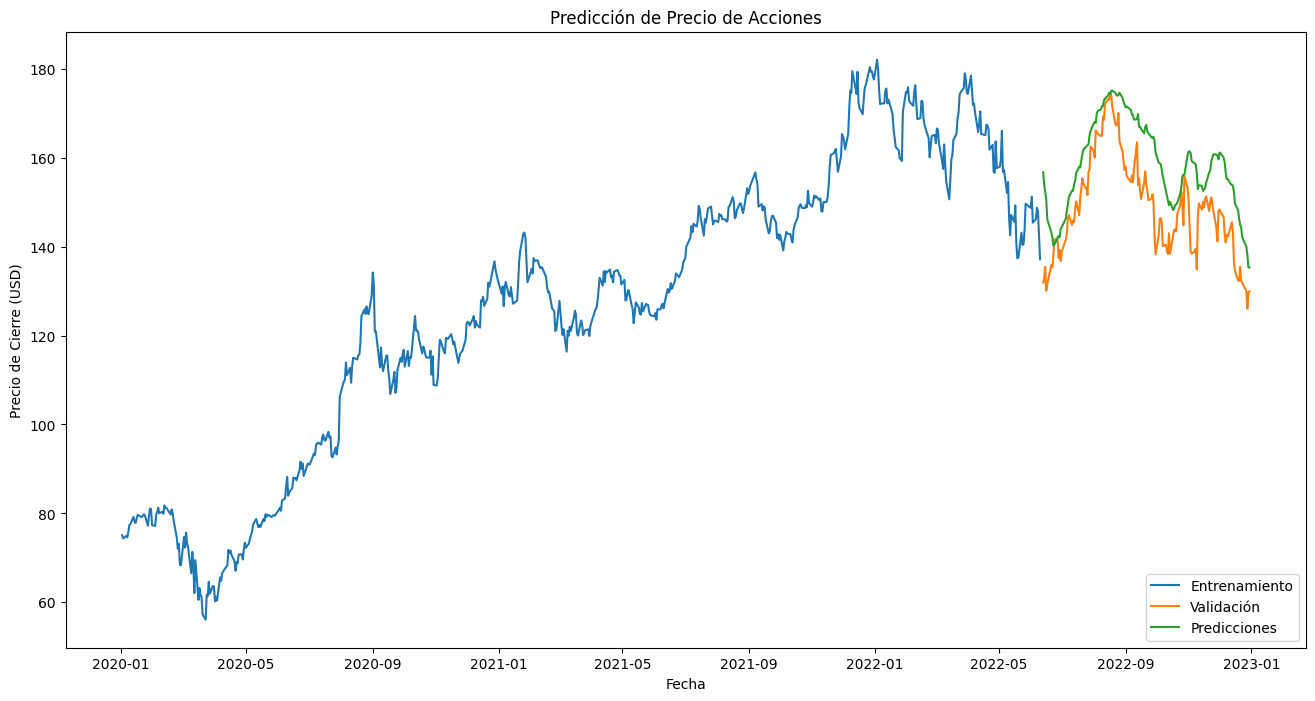

                 Close  Predictions
Date                               
2022-12-23  131.860001   142.081288
2022-12-27  130.029999   140.005886
2022-12-28  126.040001   138.227483
2022-12-29  129.610001   135.344957
2022-12-30  129.929993   135.264764


In [ ]:

def plot_results(data, train_size, predictions):
    """
    Visualiza los resultados de las predicciones frente a los valores reales.
    """
    train = data[:train_size + sequence_length]
    valid = data[train_size + sequence_length:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16, 8))
    plt.title('Predicción de Precio de Acciones')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre (USD)')
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Entrenamiento', 'Validación', 'Predicciones'], loc='lower right')
    plt.show()

    print(valid[['Close', 'Predictions']].tail())

# Visualización de los resultados
plot_results(data, train_size, predictions)


## Función para Predicción Manual

Se realiza una predicción manual del próximo valor en la secuencia usando los datos más recientes.


In [ ]:
def predict_manual(model, X_test):
    """
    Realiza una predicción manual del siguiente valor de la secuencia.
    """
    model.eval()
    with torch.no_grad():
        new_sequence = X_test[-1].unsqueeze(0)

        hidden_cell = model.init_hidden(1)

        # Realizar la predicción con el estado oculto
        predicted_price, hidden_cell = model(new_sequence, hidden_cell)
        predicted_price = predicted_price.item() * (np.max(close_data) - np.min(close_data)) + np.min(close_data)

    print(f'Predicción manual del próximo precio de cierre: {predicted_price} USD')

# Predicción manual
predict_manual(model, X_test)


Predicción manual del próximo precio de cierre: 135.26476366864244 USD
